In [1]:
import sys

sys.path.append("..")

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split

from hooks import HookManager
from models import FFN, FFN2, FFNResidual, FFNKai, FFNSiLU, FFNLReLU
from api.src.trainer import SampleDataset, seed_all

In [2]:
seed_all()
cov_type = fetch_covtype(data_home="../covertype")
X_train, X_test, y_train, y_test = train_test_split(
    cov_type.data, cov_type.target, test_size=0.2, random_state=42
)
train_dataset = SampleDataset(X_train, y_train)
test_dataset = SampleDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=len(y_test), shuffle=False)

In [3]:
np.save("test.npy", X_test)

In [4]:
np.save("test_y.npy", y_test)

In [5]:
model1 = FFN(X_train.shape[1], len(set(y_train)))
model2 = FFN2(X_train.shape[1], len(set(y_train)))
# model2 = FFNResidual(X_train.shape[1], len(set(y_train)))
# model2 = FFNKai(X_train.shape[1], len(set(y_train)))
# model2 = FFNSiLU(X_train.shape[1], len(set(y_train)))
# model2 = FFNLReLU(X_train.shape[1], len(set(y_train)))
# model2 = FFN(X_train.shape[1], len(set(y_train)))

In [6]:
model1.load_state_dict(
    torch.load(
        "../model/ffn_covtype_v1.pth",
        map_location=torch.device("cpu"),
        weights_only=True,
    )
)

# model2.load_state_dict(
#     torch.load(
#         "../model/ffn_covtype_v1_lr00001.pth",
#         map_location=torch.device("cpu"),
#         weights_only=True,
#     )
# )
model2.load_state_dict(
    torch.load(
        "../model/ffn_covtype_v2.pth",
        map_location=torch.device("mps"),
        weights_only=True,
    )
)

# model2.load_state_dict(
#     torch.load(
#         "../model/ffn_covtype_v1residual.pth",
#         map_location=torch.device("mps"),
#         weights_only=True,
#     )
# )

# model2.load_state_dict(
#     torch.load(
#         "../model/ffn_covtype_v1kai.pth",
#         map_location=torch.device("mps"),
#         weights_only=True,
#     )
# )

# model2.load_state_dict(
#     torch.load(
#         "../model/ffn_covtype_v1silu.pth",
#         map_location=torch.device("mps"),
#         weights_only=True,
#     )
# )

# model2.load_state_dict(
#     torch.load(
#         "../model/ffn_covtype_v1lrelu.pth",
#         map_location=torch.device("mps"),
#         weights_only=True,
#     )
# )

<All keys matched successfully>

In [7]:
print("testing...")
model1.eval()
model2.eval()
model1_hook_mgr = HookManager(track_all=True)
model1_hook_mgr.register_hooks(model1, partial_matches=["ALL"])
model2_hook_mgr = HookManager(track_all=True)
model2_hook_mgr.register_hooks(model2, partial_matches=["ALL"])

for ts_x, ts_y in test_loader:
    ts_x = torch.tensor(ts_x, dtype=torch.float32)
    ts_y = torch.tensor(ts_y, dtype=torch.long)
    pred_y_test_1 = model1(ts_x)
    pred_y_test_2 = model2(ts_x)
    loss1 = nn.CrossEntropyLoss()(pred_y_test_1, ts_y)
    loss2 = nn.CrossEntropyLoss()(pred_y_test_2, ts_y)
    loss1.backward()
    loss2.backward()
    clf_1 = torch.argmax(pred_y_test_1, dim=-1)
    clf_2 = torch.argmax(pred_y_test_2, dim=-1)
    acc1 = (clf_1 == ts_y).float().mean().item()
    acc2 = (clf_2 == ts_y).float().mean().item()
    print(f"Test Accuracy 1: {acc1}")
    print(f"Test Accuracy 2: {acc2}")
    print(f"Test Loss 1: {loss1.item()}")
    print(f"Test Loss 2: {loss2.item()}")
    break

testing...
Test Accuracy 1: 0.828125
Test Accuracy 2: 0.421875
Test Loss 1: 1.3329094648361206
Test Loss 2: 1.747016429901123


/Users/abnerteng/git/repviz/notebooks/../hooks.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(module.weight).detach().cpu()
/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_7913/3564778694.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_x = torch.tensor(ts_x, dtype=torch.float32)
/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_7913/3564778694.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_y = torch.tensor(ts_y, dtype=torch.long)


In [8]:
import ast
import re


def parse_args_kwargs_from_repr(repr_str: str):
    """
    Parse the positional args and keyword args from a nn.Module repr string.

    Example:
        "LayerNorm((54,), eps=1e-05, elementwise_affine=True)"
        --> args: ((54,),), kwargs: {'eps': 1e-05, 'elementwise_affine': True}
    """
    # Match the first '(' to the last ')' to get argument section
    match = re.search(r"\((.*)\)", repr_str)
    if not match:
        return (), {}

    content = match.group(1).strip()
    args = []
    kwargs = {}

    # This regex splits by commas not inside parentheses
    tokens = re.findall(r"(?:[^,(]|\([^)]*\))+", content)

    for token in tokens:
        token = token.strip()
        if not token:
            continue
        if "=" in token:
            key, val = token.split("=", 1)
            try:
                kwargs[key.strip()] = ast.literal_eval(val.strip())
            except Exception:
                kwargs[key.strip()] = val.strip()  # fallback: string
        else:
            try:
                args.append(ast.literal_eval(token))
            except Exception:
                args.append(token.strip())  # fallback: string

    if len(args) == 0:
        args = "None"
    if len(kwargs) == 0:
        kwargs = "None"

    return args, kwargs


infos = {}
for name, module in model1.named_modules():
    if len(list(module.children())) == 0:
        args, kwargs = parse_args_kwargs_from_repr(str(module))
        module_type = str(module).split("(")[0].strip()
        infos[name] = {
            "module_type": module_type,
            "args": args,
            "kwargs": kwargs,
        }

print(infos)

{'ffn.0': {'module_type': 'LayerNorm', 'args': [(54,)], 'kwargs': {'eps': 1e-05, 'elementwise_affine': True}}, 'ffn.1': {'module_type': 'Dropout', 'args': 'None', 'kwargs': {'p': 0.1, 'inplace': False}}, 'ffn.2': {'module_type': 'Linear', 'args': 'None', 'kwargs': {'in_features': 54, 'out_features': 512, 'bias': True}}, 'ffn.3': {'module_type': 'ReLU', 'args': 'None', 'kwargs': 'None'}, 'ffn.4': {'module_type': 'LayerNorm', 'args': [(512,)], 'kwargs': {'eps': 1e-05, 'elementwise_affine': True}}, 'ffn.5': {'module_type': 'Dropout', 'args': 'None', 'kwargs': {'p': 0.1, 'inplace': False}}, 'ffn.6': {'module_type': 'Linear', 'args': 'None', 'kwargs': {'in_features': 512, 'out_features': 512, 'bias': True}}, 'ffn.7': {'module_type': 'ReLU', 'args': 'None', 'kwargs': 'None'}, 'ffn.8': {'module_type': 'LayerNorm', 'args': [(512,)], 'kwargs': {'eps': 1e-05, 'elementwise_affine': True}}, 'ffn.9': {'module_type': 'Dropout', 'args': 'None', 'kwargs': {'p': 0.1, 'inplace': False}}, 'ffn.10': {'mod

In [9]:
inputs1 = model1_hook_mgr.get_inputs()
gradients1 = model1_hook_mgr.get_gradients()
weights1 = model1_hook_mgr.get_weights()
activs1 = model1_hook_mgr.get_activations()


inputs2 = model2_hook_mgr.get_inputs()
gradients2 = model2_hook_mgr.get_gradients()
weights2 = model2_hook_mgr.get_weights()
activs2 = model2_hook_mgr.get_activations()

In [10]:
import matplotlib.pyplot as plt
import plotly.express as px
import umap.umap_ as umap


def plot_gradient_norms_from_hook(hook_manager: HookManager, step: int):
    gradients = hook_manager.get_gradients()
    norms = {name: grad.norm(2).item() for name, grad in gradients.items()}

    plt.figure(figsize=(10, 5))
    plt.bar(norms.keys(), norms.values())
    plt.title(f"L2 Norm of Gradients per Layer @ Step {step}")
    plt.ylabel("L2 Norm")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def plot_snr_from_hook(hook_manager: HookManager):
    gradients = hook_manager.get_gradients()
    snr = {}

    for name, grad in gradients.items():
        mean = grad.mean().item()
        std = grad.std().item()
        snr[name] = abs(mean) / std if std > 1e-8 else 0.0

    plt.figure(figsize=(10, 5))
    plt.bar(snr.keys(), snr.values(), color="orange")
    plt.title("Gradient Signal-to-Noise Ratio (|mean| / std)")
    plt.ylabel("SNR")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def plot_weight_spectrum_from_hook(hook_manager: HookManager):
    weights = hook_manager.get_weights()
    for name, w in weights.items():
        if w.ndim == 2:
            try:
                eigvals = np.linalg.eigvals(w.numpy())
                plt.figure()
                plt.hist(np.real(eigvals), bins=50, alpha=0.7)
                plt.title(f"Eigenvalue Spectrum of {name}")
                plt.xlabel("Eigenvalue")
                plt.ylabel("Frequency")
                plt.tight_layout()
                plt.show()
            except np.linalg.LinAlgError:
                print(f"[Warning] Failed eigval computation for {name}")


def interactive_umap_analysis(activations: torch.Tensor, predictions, labels, losses):
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="cosine")
    embedding_2d = reducer.fit_transform(activations.numpy())

    fig = px.scatter(
        x=embedding_2d[:, 0],
        y=embedding_2d[:, 1],
        color=losses,
        hover_data={"Prediction": predictions, "Label": labels, "Loss": losses},
        labels={"x": "UMAP-1", "y": "UMAP-2", "color": "Loss"},
    )
    fig.update_layout(title="UMAP Visualization of Activations with Loss Coloring")
    fig.show()

/Users/abnerteng/git/repviz/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
for k, v in activs1.items():
    print(f"{k}: {v.shape}")
print()
for k, v in activs2.items():
    print(f"{k}: {v.shape}")
print()
for k, v in weights1.items():
    print(f"{k}: {v.shape}")
print()
for k, v in weights2.items():
    print(f"{k}: {v.shape}")

LayerNorm:0: torch.Size([1, 64, 54])
Dropout:0: torch.Size([1, 64, 54])
Linear:0: torch.Size([1, 64, 512])
ReLU:0: torch.Size([1, 64, 512])
LayerNorm:1: torch.Size([1, 64, 512])
Dropout:1: torch.Size([1, 64, 512])
Linear:1: torch.Size([1, 64, 512])
ReLU:1: torch.Size([1, 64, 512])
LayerNorm:2: torch.Size([1, 64, 512])
Dropout:2: torch.Size([1, 64, 512])
Linear:2: torch.Size([1, 64, 7])
Softmax:0: torch.Size([1, 64, 7])

BatchNorm1d:0: torch.Size([1, 64, 54])
Dropout:0: torch.Size([1, 64, 54])
Linear:0: torch.Size([1, 64, 512])
LeakyReLU:0: torch.Size([1, 64, 512])
BatchNorm1d:1: torch.Size([1, 64, 512])
Dropout:1: torch.Size([1, 64, 512])
Linear:1: torch.Size([1, 64, 512])
LeakyReLU:1: torch.Size([1, 64, 512])
BatchNorm1d:2: torch.Size([1, 64, 512])
Dropout:2: torch.Size([1, 64, 512])
Linear:2: torch.Size([1, 64, 7])
Softmax:0: torch.Size([1, 64, 7])

LayerNorm:0: torch.Size([54])
Linear:0: torch.Size([512, 54])
LayerNorm:1: torch.Size([512])
Linear:1: torch.Size([512, 512])
LayerNorm:

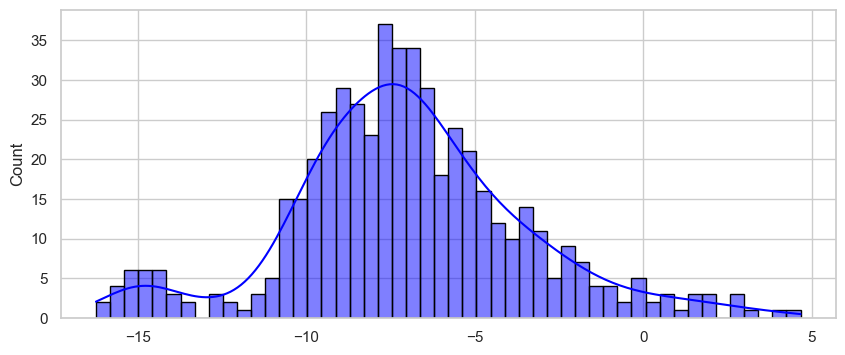

In [12]:
import seaborn as sns

# plt.style.use("default")
# plt.figure(figsize=(10, 6))

sns.set(style="whitegrid")
x, y = (
    activs1["Linear:0"][0].mean(axis=0).detach().numpy(),
    activs1["ReLU:0"][0].mean(axis=0).detach().numpy(),
)
# Assume x and y are your layer inputs/outputs
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(x, y, c=y, cmap="viridis", alpha=0.7, edgecolor="k", s=60)

# Axis labels and title
# plt.xlabel("Input to ReLU", fontsize=14)
# plt.ylabel("Output of ReLU", fontsize=14)
# plt.title("Layer Input vs Output (ReLU)", fontsize=16)

# Add colorbar if needed
# cbar = plt.colorbar(scatter)
# cbar.set_label("Output Value")

# plt.tight_layout()
# plt.show()
plt.figure(figsize=(10, 4))
sns.histplot(
    activs1["Linear:1"][0].mean(axis=0).detach().numpy(),
    bins=50,
    kde=True,
    color="blue",
    edgecolor="black",
    label="Linear:1 Mean Activation",
)
plt.show()

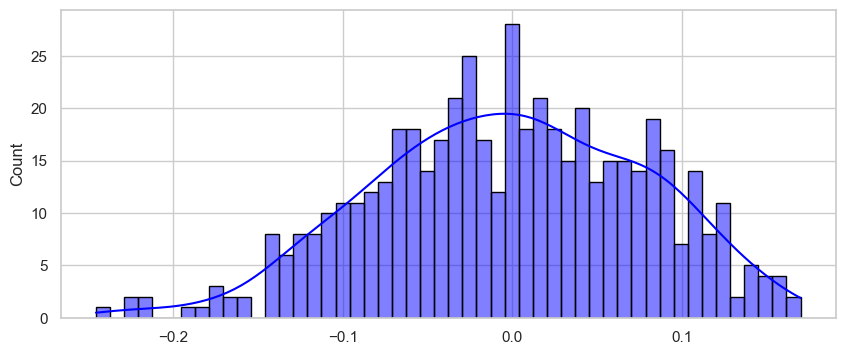

In [13]:
plt.figure(figsize=(10, 4))
sns.histplot(
    weights1["Linear:1"].mean(axis=0).detach().numpy(),
    bins=50,
    kde=True,
    color="blue",
    edgecolor="black",
    label="Linear:1 Mean Weights",
)
plt.show()

In [14]:
gradients1["Linear:1"].shape

torch.Size([1, 64, 512])

/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_7913/1594880879.py:1: RuntimeWarning: divide by zero encountered in log
  g = np.log(gradients1["Linear:1"].view(-1).detach().numpy())
/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_7913/1594880879.py:1: RuntimeWarning: invalid value encountered in log
  g = np.log(gradients1["Linear:1"].view(-1).detach().numpy())


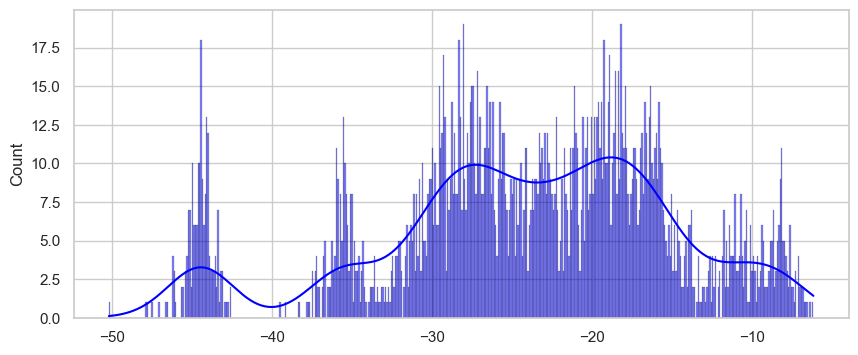

In [15]:
g = np.log(gradients1["Linear:1"].view(-1).detach().numpy())
plt.figure(figsize=(10, 4))
sns.histplot(
    g,
    bins=500,
    kde=True,
    color="blue",
    edgecolor="black",
    label="Linear:1 Mean Weights",
)
plt.show()

## CKA similarity

In [16]:
def gram_linear(x):
    return x @ x.T


def center_gram(gram, unbiased=False):
    """Center a symmetric Gram matrix.

    This is equvialent to centering the (possibly infinite-dimensional) features
    induced by the kernel before computing the Gram matrix.

    Args:
        gram: A num_examples x num_examples symmetric matrix.
        unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
        estimate of HSIC. Note that this estimator may be negative.

    Returns:
        A symmetric matrix with centered columns and rows.
    """
    if not np.allclose(gram, gram.T):
        raise ValueError("Input must be a symmetric matrix.")
    gram = gram.copy()

    if unbiased:
        # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
        # L. (2014). Partial distance correlation with methods for dissimilarities.
        # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
        # stable than the alternative from Song et al. (2007).
        n = gram.shape[0]
        np.fill_diagonal(gram, 0)
        means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
        means -= np.sum(means) / (2 * (n - 1))
        gram -= means[:, None]
        gram -= means[None, :]
        np.fill_diagonal(gram, 0)
    else:
        means = np.mean(gram, 0, dtype=np.float64)
        means -= np.mean(means) / 2
        gram -= means[:, None]
        gram -= means[None, :]

    return gram


def cka(gram_x, gram_y, debiased=False):
    """Compute CKA.

    Args:
        gram_x: A num_examples x num_examples Gram matrix.
        gram_y: A num_examples x num_examples Gram matrix.
        debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
        The value of CKA between X and Y.
    """
    gram_x = center_gram(gram_x, unbiased=debiased)
    gram_y = center_gram(gram_y, unbiased=debiased)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels for CKA.
    scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

    normalization_x = np.linalg.norm(gram_x)
    normalization_y = np.linalg.norm(gram_y)
    return scaled_hsic / (normalization_x * normalization_y)

In [17]:
# used_activs1 = {k: v for k, v in activs1.items() if "Linear" in k or "Norm" in k}
# used_activs2 = {k: v for k, v in activs2.items() if "Linear" in k or "Norm" in k}
used_activs1 = activs1
used_activs2 = activs2
print(f"Used Activations 1: {len(used_activs1)}")
print(f"Used Activations 2: {len(used_activs2)}")
cka_matrices = np.empty((len(used_activs1), len(used_activs2)))

for i, (k1, v1) in enumerate(used_activs1.items()):
    # if "Linear" in k1 or "Norm" in k1:
    for j, (k2, v2) in enumerate(used_activs2.items()):
        # if "Linear" in k2 or "Norm" in k2:
        cka_value = cka(
            gram_linear(v1.numpy().mean(axis=0)),
            gram_linear(v2.numpy().mean(axis=0)),
        )
        cka_matrices[len(used_activs1) - i - 1, j] = cka_value

Used Activations 1: 12
Used Activations 2: 12


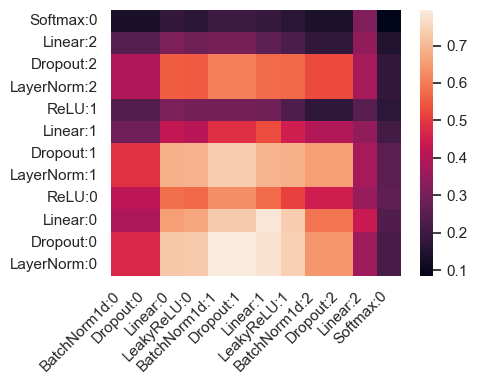

In [18]:
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(
    cka_matrices,
    annot=False,
    fmt=".2f",
    xticklabels=list(used_activs2.keys()),
    yticklabels=list(used_activs1.keys())[::-1],
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()